# Read and Examination of Data

In [14]:
# Import  pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import statsmodels.api as sm
import random
# Import matplotlib, seaborn for visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Import the data
df = pd.read_csv(r'C:\Users\danijel\Desktop\DataScience\data_final.csv')
# Nameing the columns of Date/Time and Temperature 
df.columns =['Date and Time', 'Temp']
# Getting rid of microseconds on dataset
df['Date and Time'] = df['Date and Time'].astype('datetime64[s]')
# Shape of dataset
print(df.shape)
# Reset the index
df.set_index('Date and Time', inplace=True)
df.head()

(383, 2)


,Temp
Date and Time,
2020-09-30 14:30:02,24.562
2020-09-30 15:00:02,24.250
2020-09-30 15:30:02,23.875
2020-09-30 16:00:02,23.875
2020-09-30 16:30:02,23.750


## Basic Analysis and Data Visualization

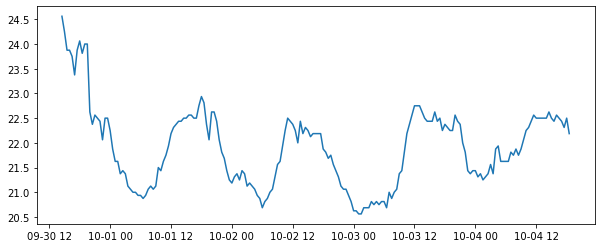

In [15]:
plt.figure(figsize=(10,4))
plt.plot(df[:200].Temp)

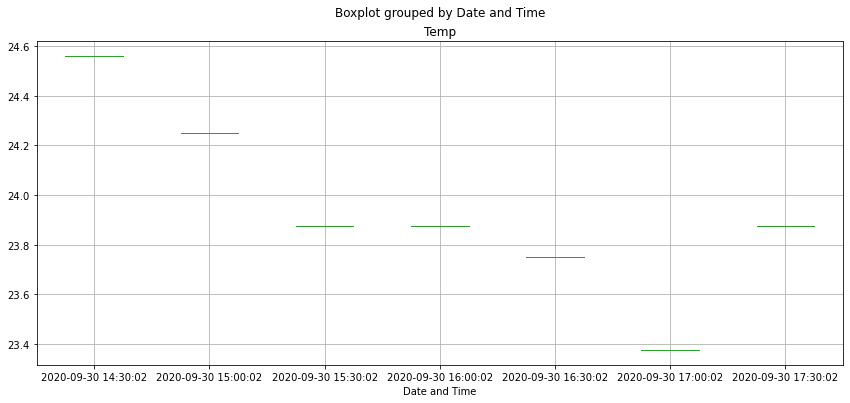

In [16]:
df[:7].boxplot(figsize=(14,6),by='Date and Time',column='Temp',vert=True)


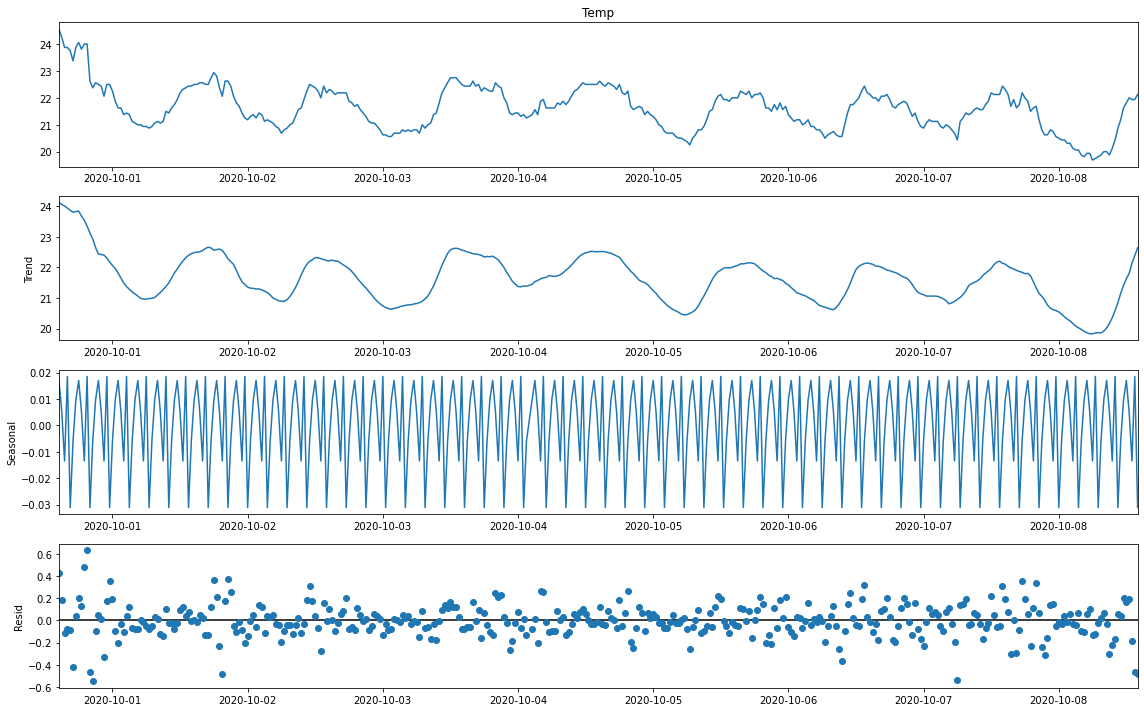

In [17]:
decomposition = sm.tsa.seasonal_decompose(df.Temp, model='additive', extrapolate_trend='freq', period=7)
plt.rcParams["figure.figsize"] = [16,10]
fig = decomposition.plot()

## Check Stationarity

In [18]:
##ARIMA model works better on a Non-Stationary data,
##that is why the first thing that we should be checking is the Stationarity of the data.
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

In [19]:
check_stationarity(df.Temp)

The test statistic: -5.313263
p-value: 0.000005
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571


The value of test statistics is less than 5% critical value and p-value is also less than 0.05 so we can reject the null hypothesis and Alternate Hypothesis that time series is Stationary seems to be true.
There is nothing unusual about the time plot and there appears to be no need to do any data adjustments.

## Differencing Data to achieve Stationarity. Also Determine value of d

In [20]:
##log transform of the original data to make the seasonality same throughout the data
ts_temp_log = np.log(df)
ts_temp_log

,Temp
Date and Time,
2020-09-30 14:30:02,3.201201
2020-09-30 15:00:02,3.188417
2020-09-30 15:30:02,3.172832
2020-09-30 16:00:02,3.172832
2020-09-30 16:30:02,3.167583
...,...
2020-10-08 12:00:02,3.082460
2020-10-08 12:30:02,3.091042
2020-10-08 13:00:02,3.088175


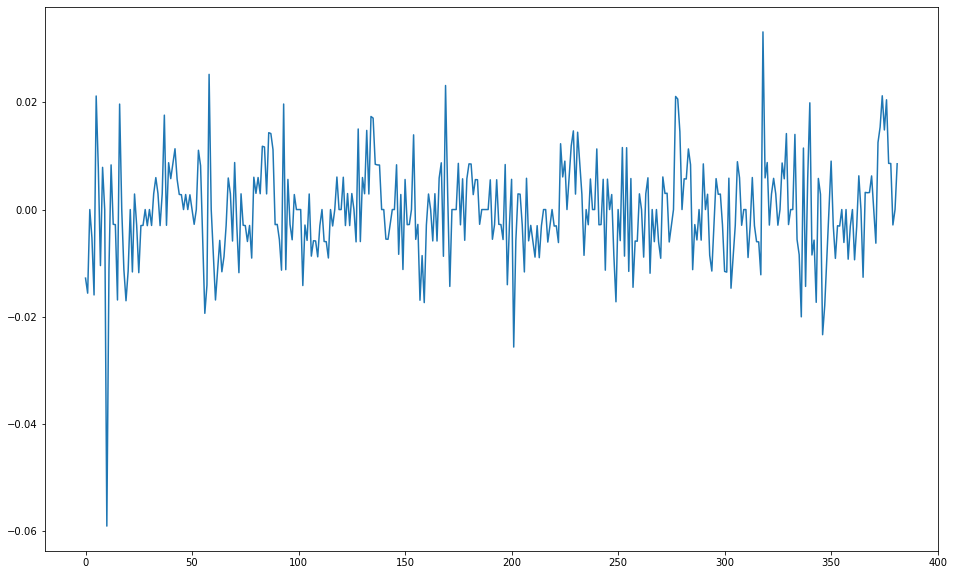

In [21]:
ts_temp_log_diff = np.diff(ts_temp_log.Temp)
## numpy diff() funtion to subtract the value with their previous value to get the difference in data.
plt.plot(ts_temp_log_diff)

In [22]:
check_stationarity(ts_temp_log_diff)

The test statistic: -6.746694
p-value: 0.000000
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571


This time the p-value is 0 which is very good and the test statistics is also less than the 5% critical.
Because our data is stationary, we are going to take 0 for d value.

## Determine P and Q value from ACF and PACF plot

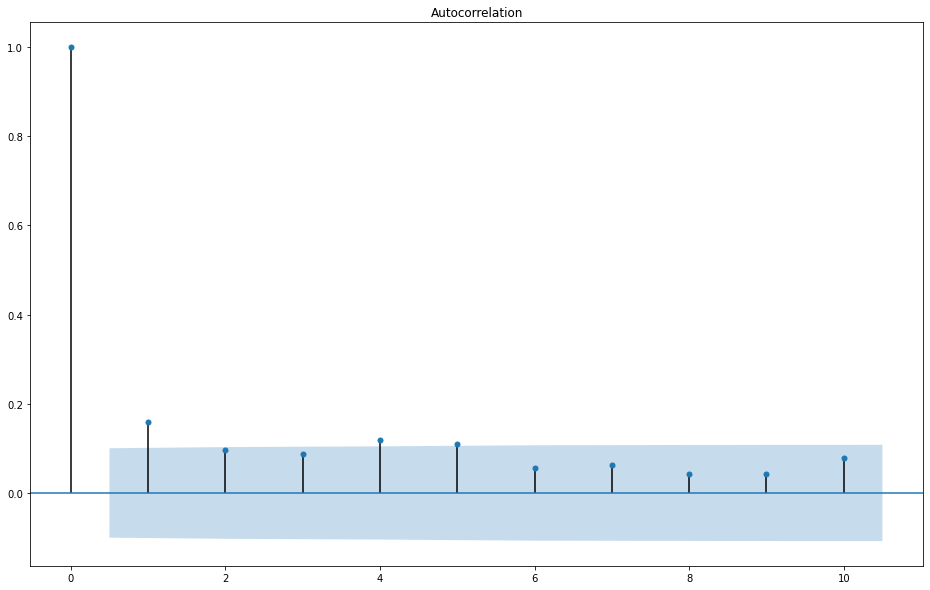

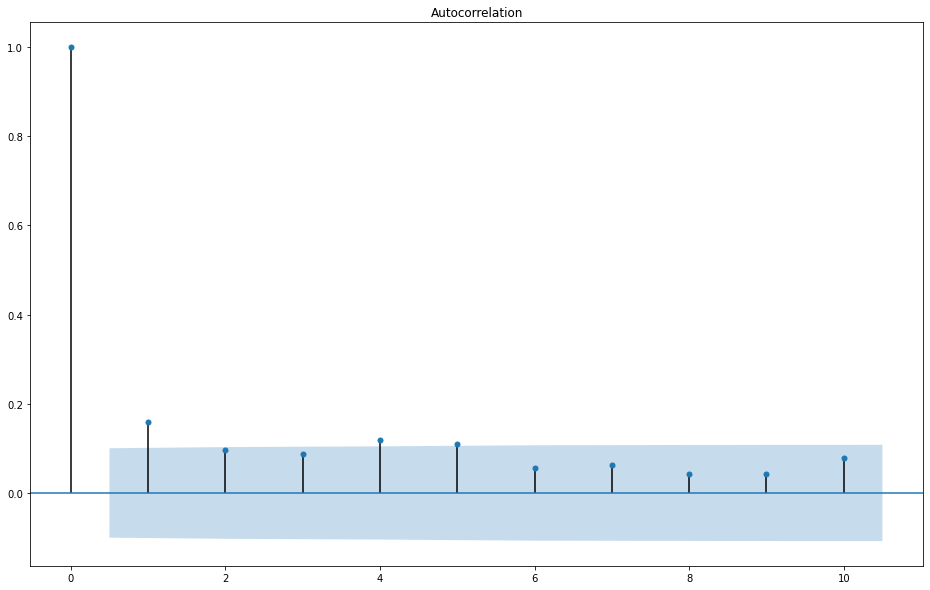

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_temp_log_diff,lags=10)

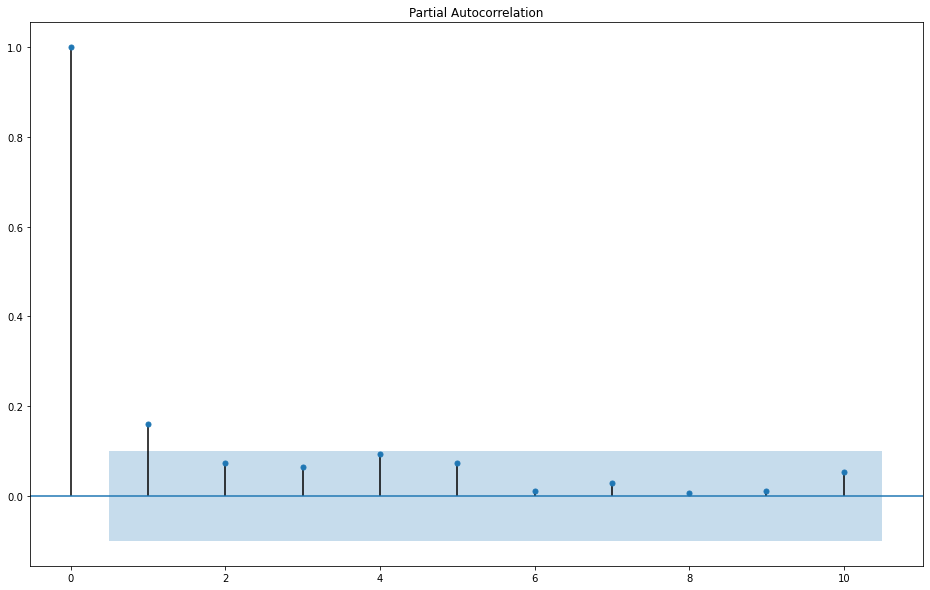

<Figure size 720x144 with 0 Axes>

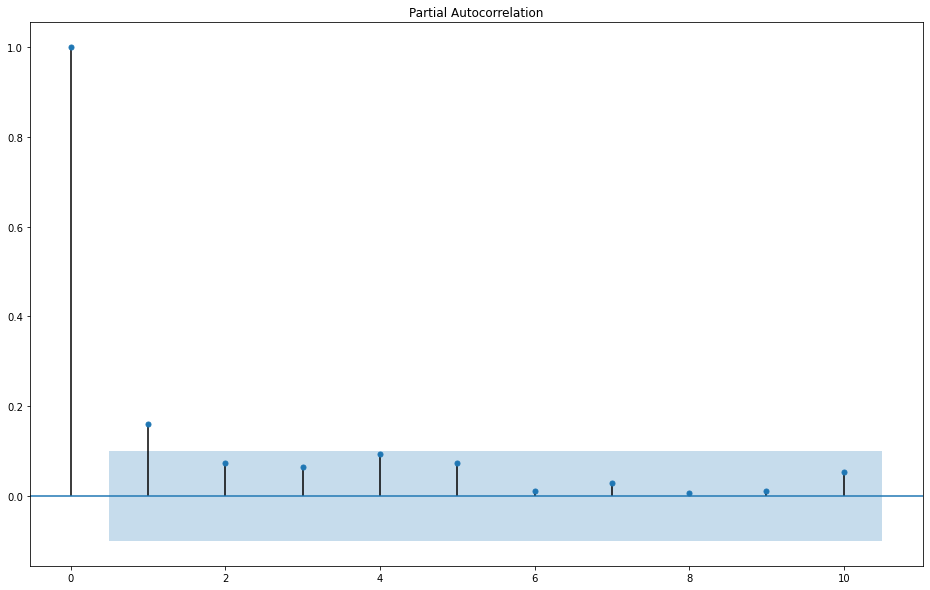

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10,2))
plot_pacf(ts_temp_log_diff,lags=10)

From the PACF plot we can see a significant correlation at lag of 2. So the PACF suggests an AR(2) model. So an inital order for the model will be (2,0,1)

## ARIMA

This sets the lag value to 2 for autoregression AR(2) and uses a data difference order of 0 since our time series is stationary, and uses a moving average model of 1.

In [25]:
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(df.Temp,order=(2,0,1))
results = mod.fit()
print(results.summary())

C:\Users\danijel\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:                   Temp   No. Observations:                  383
Model:                     ARMA(2, 1)   Log Likelihood                  93.604
Method:                       css-mle   S.D. of innovations              0.189
Date:                Tue, 10 Nov 2020   AIC                           -177.207
Time:                        17:32:26   BIC                           -157.467
Sample:                             0   HQIC                          -169.377
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6605      0.114    190.799      0.000      21.438      21.883
ar.L1.Temp     1.9441      0.024     81.928      0.000       1.898       1.991
ar.L2.Temp    -0.9544      0.023    -41.028      0.0

## Residuals Diagnosis

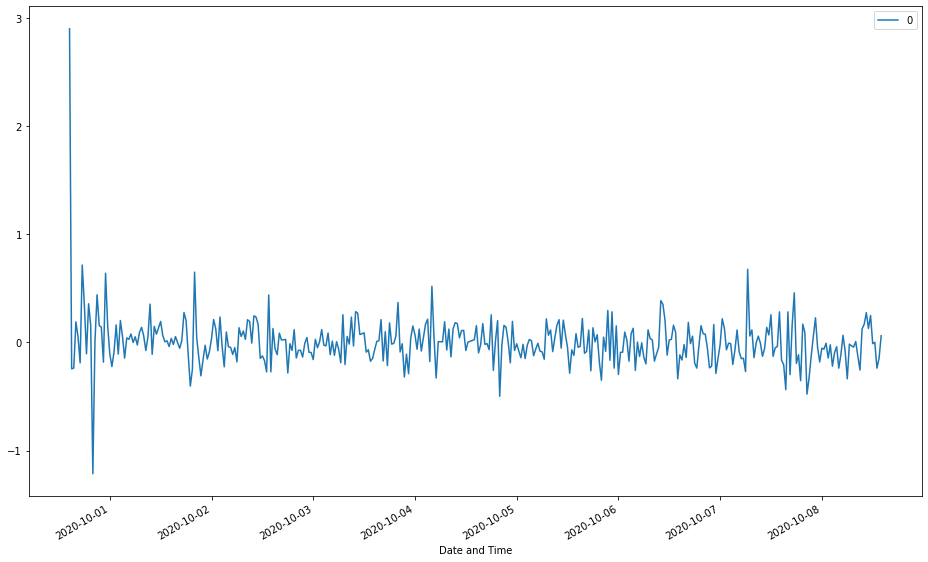

In [26]:
##model residuals is difference between the predicted and expected value and can be verified using resid().
residuals = pd.DataFrame(results.resid)
residuals.plot()

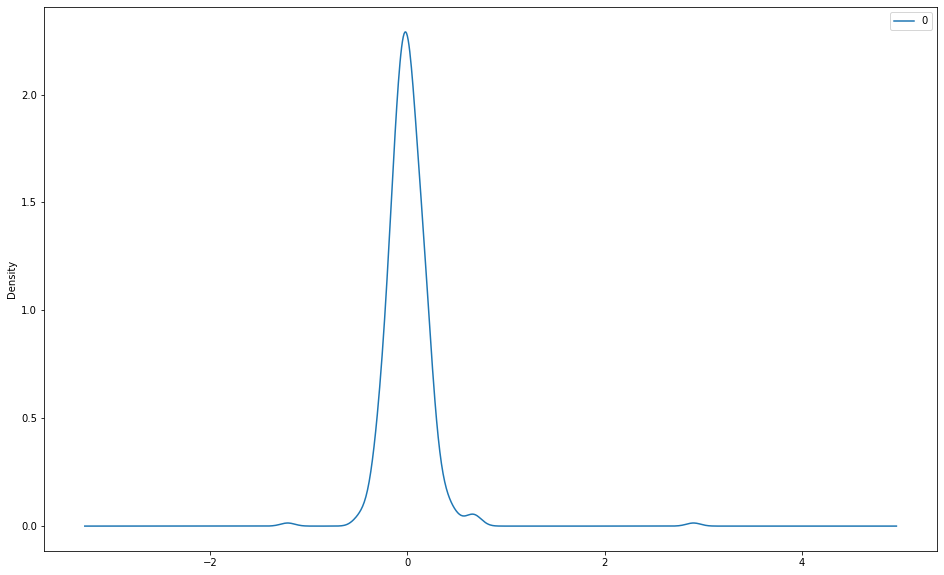

In [27]:
residuals.plot(kind='kde')

The mean of the residual is close to Zero and there is no significant correlation also that we can see in the pacf plot for residuals

In [28]:
residuals.describe()

,0
count,383.000000
mean,0.004662
std,0.238564
min,-1.214723
25%,-0.113337
50%,-0.008970
75%,0.112443
max,2.901467


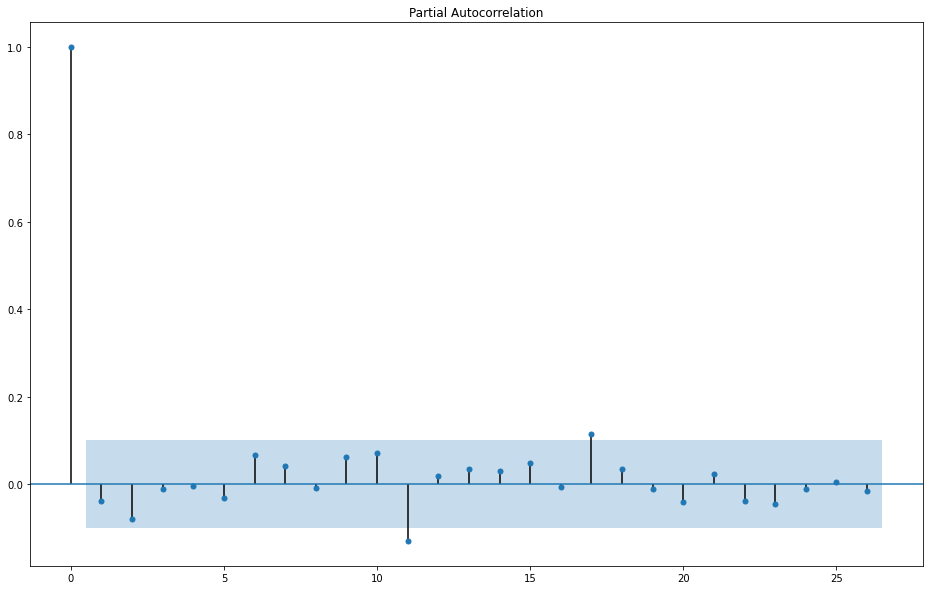

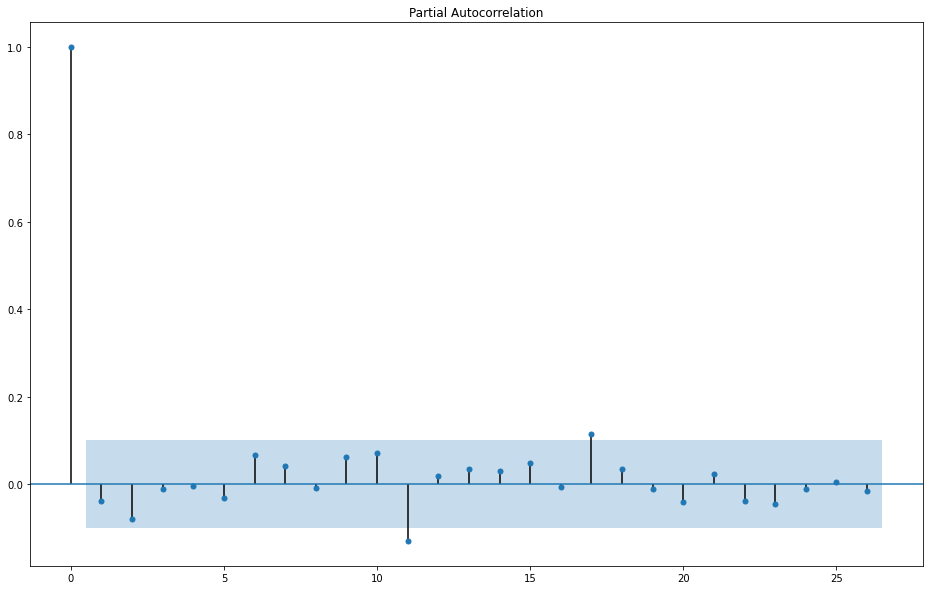

In [29]:
plot_pacf(residuals)

## Arima Predict

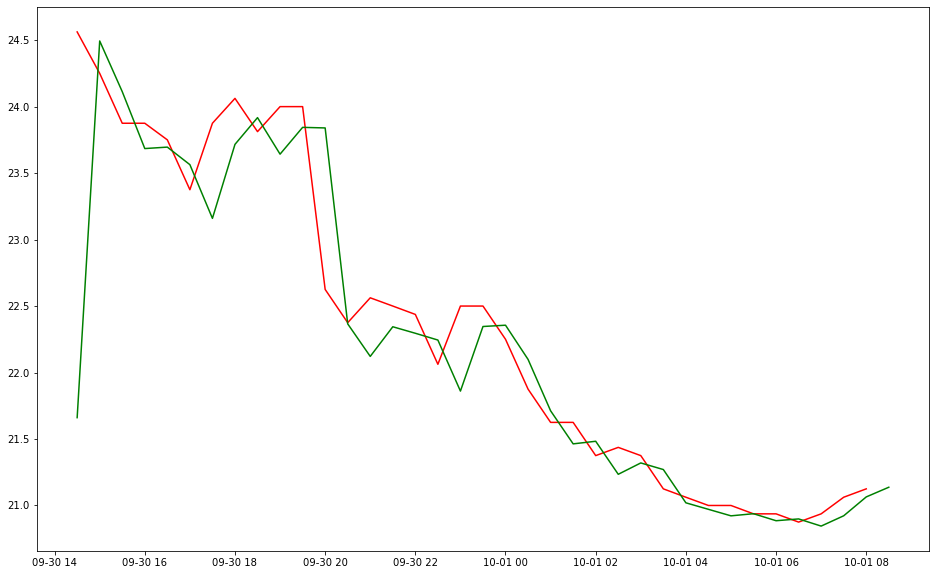

In [30]:
from math import sqrt
from sklearn.metrics import mean_squared_error
plt.plot(df.Temp[:36],color='r')
plt.plot(results.predict(0,36),color='g')

In [31]:
rmse =sqrt(mean_squared_error(df.Temp, results.predict()))
print(rmse)

0.2382982579748481


Everything looks good. Prediction look okay,
and our RMSE is very small beacuse we are predictiong room temperature and our data is not that 

## Forecast

We are forecasting the temperature for next 3 years i.e. 36 months so our steps will be 36 and for a confidence interval of 95% we will pass the alpha value as 0.05.

In [32]:
n=36
forecast,err,ci = results.forecast(steps=n,alpha=0.05)

df_forecast = pd.DataFrame({'forecast':forecast},index=pd.date_range(start='2020-09-30 14:30:02', periods=n, freq='MS'))
df_forecast.head(10)

,forecast
2020-10-01 14:30:02,22.245692
2020-11-01 14:30:02,22.354855
2020-12-01 14:30:02,22.451890
2021-01-01 14:30:02,22.536353
2021-02-01 14:30:02,22.607947
2021-03-01 14:30:02,22.666524
2021-04-01 14:30:02,22.712073
2021-05-01 14:30:02,22.744721
2021-06-01 14:30:02,22.764720
2021-07-01 14:30:02,22.772442


## Forecast Interval

The confidence interval of the forecast is also returned by the ARIMAResult object -> ci().

In [33]:
ci

array([[21.87607024, 22.61531453],
       [21.8156287 , 22.89408124],
       [21.77418421, 23.12959635],
       [21.73727326, 23.33543261],
       [21.69990825, 23.5159863 ],
       [21.65992683, 23.67312034],
       [21.61633627, 23.80780964],
       [21.56871975, 23.9207222 ],
       [21.51697519, 24.01246539],
       [21.46118353, 24.08370086],
       [21.40153518, 24.13519966],
       [21.33828561, 24.16786675],
       [21.27172676, 24.18274852],
       [21.20216802, 24.18103   ],
       [21.12992333, 24.16402522],
       [21.05530253, 24.13316296],
       [20.97860629, 24.08996898],
       [20.90012381, 24.03604542],
       [20.82013316, 23.9730481 ],
       [20.73890398, 23.90266191],
       [20.65670242, 23.82657487],
       [20.57379781, 23.74645131],
       [20.49047076, 23.66390488],
       [20.4070219 , 23.58047202],
       [20.32378043, 23.49758717],
       [20.24111155, 23.41656051],
       [20.15942163, 23.3385596 ],
       [20.07916029, 23.26459572],
       [20.00081863,

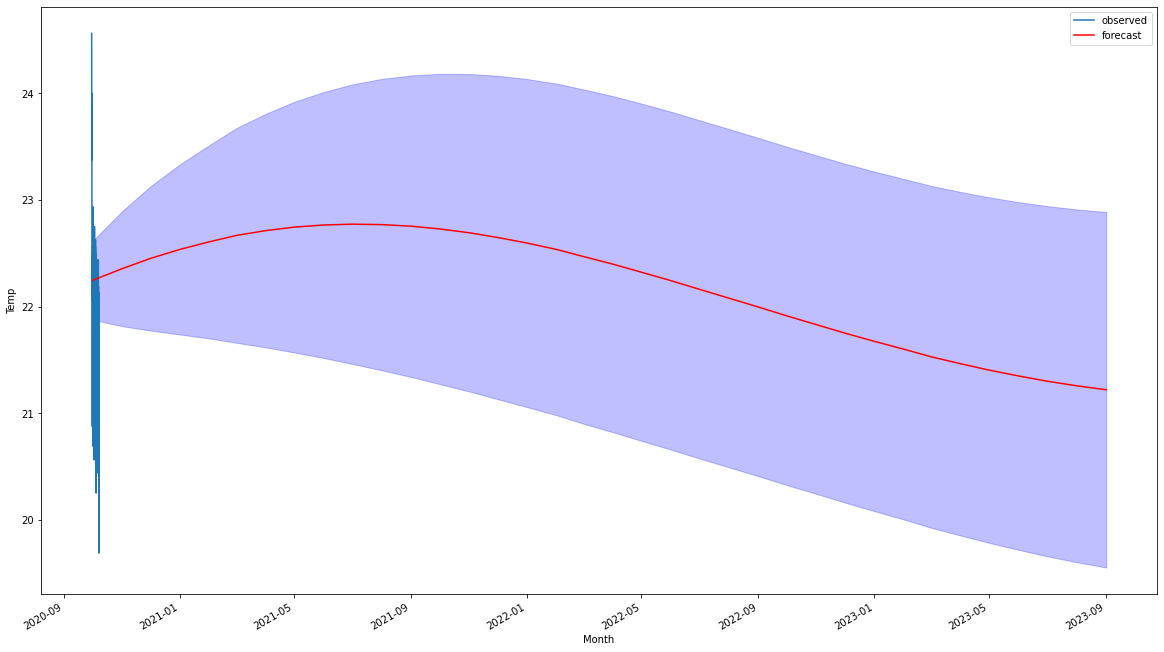

In [49]:
ax = df[0:].Temp.plot(label='observed', figsize=(20, 12))
df_forecast.plot(ax=ax,label='Forecast',color='r')
ax.fill_between(df_forecast.index,
                ci[:,0],
                ci[:,1], color='b', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Temp')

plt.legend()
plt.show()

On this graph, it show les of observed because data of mesured temperature is only 7 days.